--- Environment Setup ---
Pandas version: 2.2.3

--- Configuration Loaded ---
Input Data Path: /mnt/nrdstor/ramamurthy/mhnarfth/internet2/journal_extension_data/journal_study_4r_57d_unaggregated.parquet
Output Figures Directory: outputs/eda
--------------------------------

--- Loading data from journal_study_4r_57d_unaggregated.parquet... ---
  ✅ Data loaded successfully.
  DataFrame contains 187,566,894 rows and covers the period from 2021-10-07 14:18:02.368000 to 2021-12-03 23:59:38.752000.
  Memory usage: 14.85 GB

--- Verifying Data Distribution in Loaded DataFrame ---
Row count per router:
router
dallas     149784626
atlanta     28032240
elpaso       9357137
boston        392891
Name: count, dtype: int64

--- Generating Plot 1: Total Traffic Volume per Router ---
  ✅ Plot saved to eda_01_total_traffic_volume.png and eda_01_total_traffic_volume.pdf


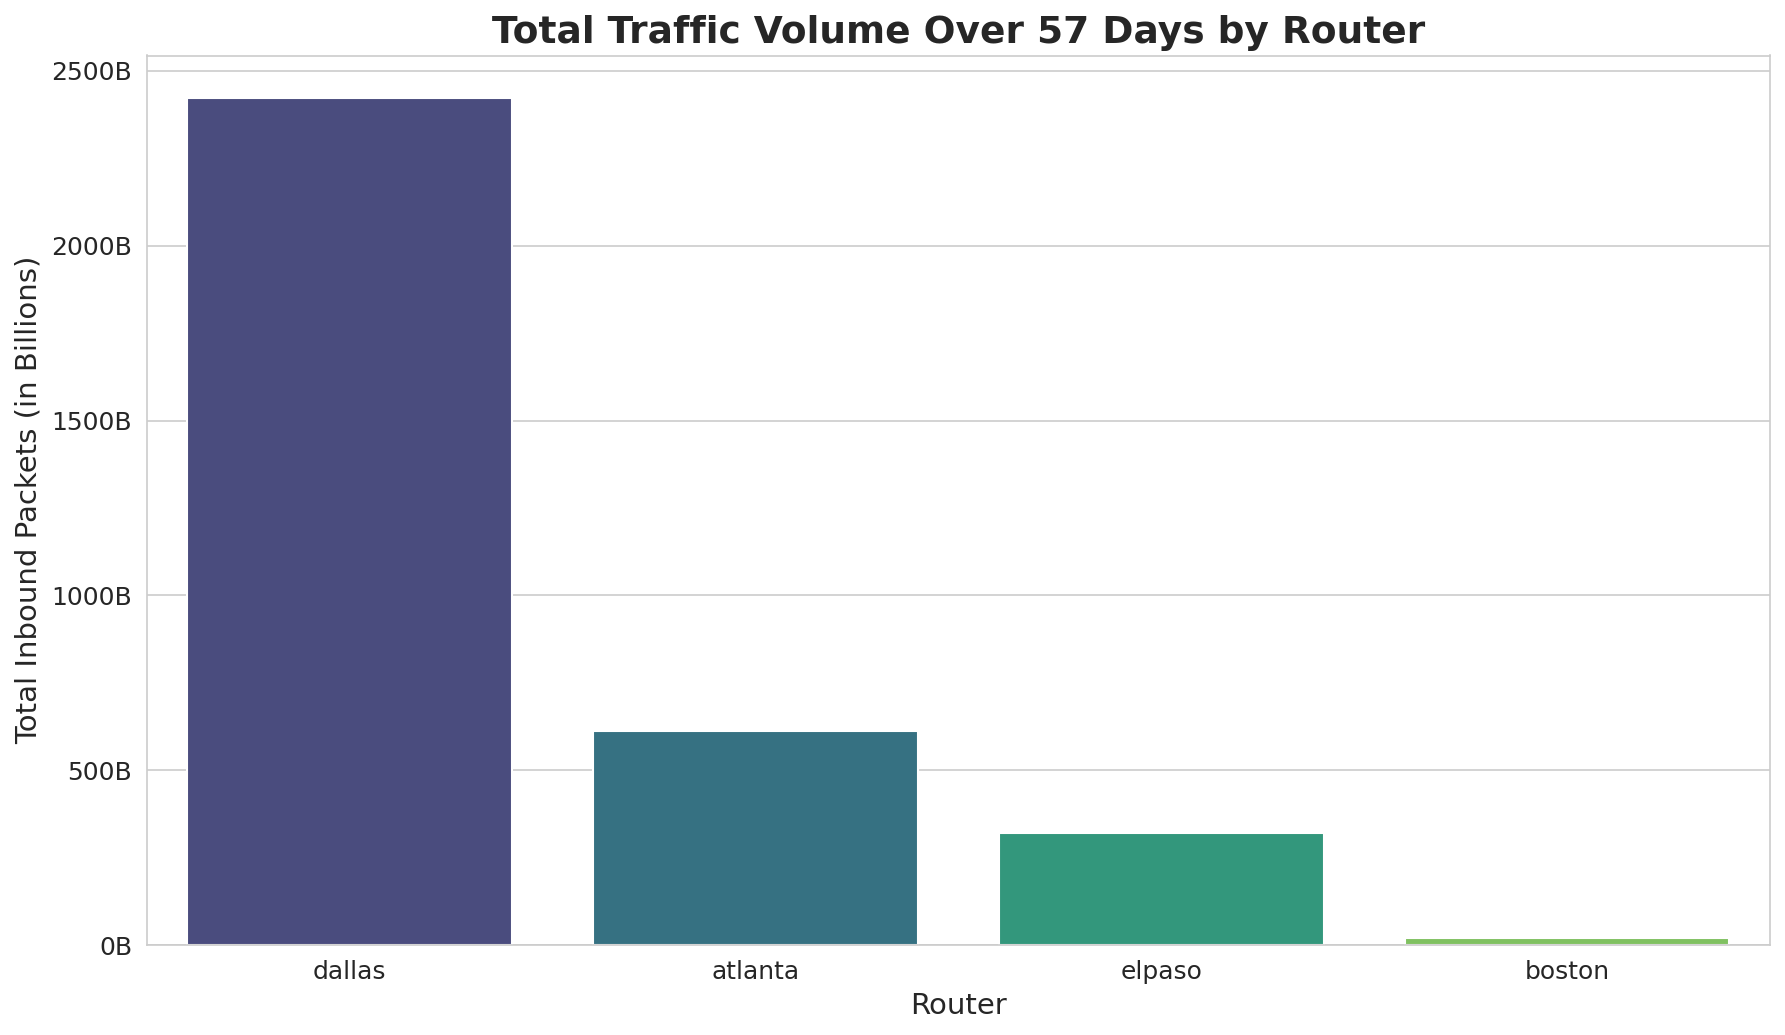


--- Generating Plot 2: Average Daily Traffic Patterns ---
  (This may take a moment as it requires resampling the entire DataFrame...)
  ✅ Plot saved to eda_02_daily_traffic_patterns.png and eda_02_daily_traffic_patterns.pdf


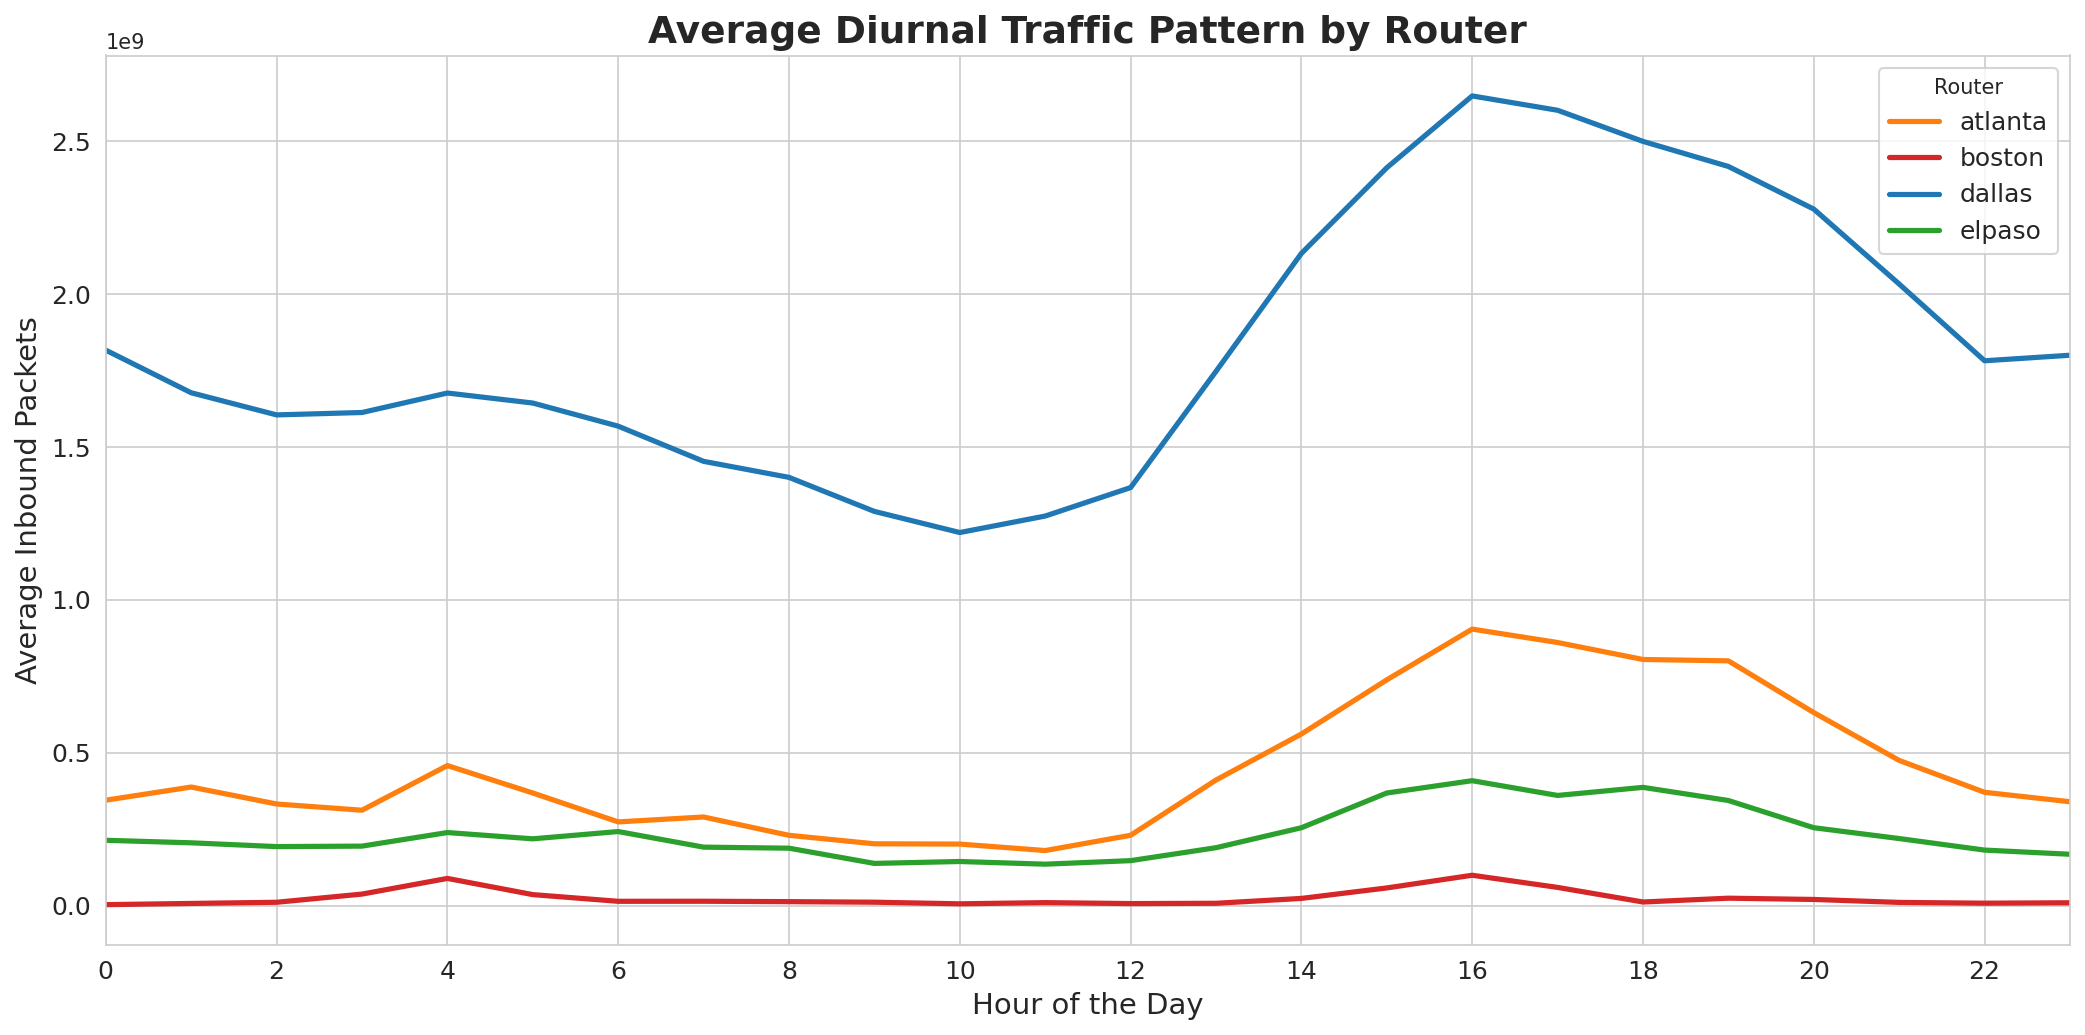


--- Notebook 02_EDA.ipynb Complete ---
All exploratory plots have been saved to the 'outputs/eda' directory.


In [8]:
#
#  notebooks/02_EDA.ipynb
#

################################################################################
#
# Notebook 2: Exploratory Data Analysis (EDA)
#
# --- PURPOSE ---
# This notebook loads the clean, consolidated "golden source" dataset created by
# `01_ETL.ipynb`. Its purpose is to perform exploratory data analysis to:
#   1. Verify the data integrity and structure.
#   2. Generate visualizations that justify the selection of the four routers by
#      highlighting their diverse traffic characteristics (volume and patterns).
#
# --- WORKFLOW ---
# This notebook should be run ONLY AFTER `01_ETL.ipynb` is complete. It can be
# re-run as many times as needed to adjust plot aesthetics without
# affecting any other part of the project.
#
################################################################################


#######################################################################
# CELL 1: ENVIRONMENT SETUP & CONFIGURATION (KNOBS)
# (Run this cell first to set up the environment)
#######################################################################

# --- Imports ---
import warnings
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker # For custom plot tick formatting

print("--- Environment Setup ---")
print(f"Pandas version: {pd.__version__}")

# --- Suppress Warnings for Cleaner Output ---
warnings.filterwarnings("ignore")

# --- Matplotlib and Seaborn Configuration ---
# Ensure plots appear inline in the Jupyter Notebook
%matplotlib inline
# Set a professional plotting style and higher resolution for quality figures
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300

# ---------------------------------------------------------------------------------
# >>> CONFIGURATION KNOBS <<<
# ---------------------------------------------------------------------------------

# --- Input Path ---
# Path to the single, un-aggregated "golden source" Parquet file from Notebook 1.
PROCESSED_DATA_PATH = Path("/mnt/nrdstor/ramamurthy/mhnarfth/internet2/journal_extension_data/journal_study_4r_57d_unaggregated.parquet")

# --- Output Path ---
# Directory where the exploratory plots will be saved.
EDA_FIGURES_DIR = Path("outputs/eda/")

# ---------------------------------------------------------------------------------

# --- Helper Function to Save Plots ---
def save_and_display_plot(fig_name: str):
    """Saves the current matplotlib figure to the EDA_FIGURES_DIR and displays it."""
    # Ensure the output directory exists
    EDA_FIGURES_DIR.mkdir(parents=True, exist_ok=True)
    
    png_path = EDA_FIGURES_DIR / f"{fig_name}.png"
    pdf_path = EDA_FIGURES_DIR / f"{fig_name}.pdf"
    
    plt.tight_layout()
    plt.savefig(png_path)
    plt.savefig(pdf_path)
    
    print(f"  ✅ Plot saved to {png_path.name} and {pdf_path.name}")
    plt.show() # Display the plot in the notebook
    plt.close() # Close the figure to free up memory

print("\n--- Configuration Loaded ---")
print(f"Input Data Path: {PROCESSED_DATA_PATH}")
print(f"Output Figures Directory: {EDA_FIGURES_DIR}")
print("--------------------------------\n")


#######################################################################
# CELL 2: DATA LOADING AND VERIFICATION
#######################################################################

print(f"--- Loading data from {PROCESSED_DATA_PATH.name}... ---")

# Initialize df as an empty DataFrame to prevent NameErrors if loading fails
df = pd.DataFrame()

if not PROCESSED_DATA_PATH.exists():
    print(f"[FATAL ERROR] Input data file not found at: {PROCESSED_DATA_PATH}")
    print("Please ensure you have run '01_ETL.ipynb' successfully before running this notebook.")
else:
    try:
        # Load the data into a Pandas DataFrame
        df = pd.read_parquet(PROCESSED_DATA_PATH)
        
        # Convert the timestamp column to datetime objects
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        
        # Set the timestamp as the DataFrame index, which is essential for time series operations
        df.set_index('timestamp', inplace=True)
        
        print(f"  ✅ Data loaded successfully.")
        print(f"  DataFrame contains {len(df):,} rows and covers the period from {df.index.min()} to {df.index.max()}.")
        print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1e9:.2f} GB")
        
        # --- Data Verification ---
        print("\n--- Verifying Data Distribution in Loaded DataFrame ---")
        router_counts = df['router'].value_counts()
        print("Row count per router:")
        print(router_counts)

    except Exception as e:
        print(f"[FATAL ERROR] An error occurred while loading or processing the data file: {e}")


##########################################################################################
# --- BLOCK FOR PLOT 1: Total Traffic Volume per Router ---
# Purpose: To visually confirm the selection of high-traffic and low-traffic routers.
##########################################################################################

#######################################################################
# CELL 3: Plotting Knobs for "Total Traffic Volume"
#######################################################################

# --- Aesthetic Knobs for Plot 1 ---
PLOT1_FIGSIZE = (12, 7)
PLOT1_PALETTE = 'viridis'
PLOT1_TITLE = 'Total Traffic Volume Over 57 Days by Router'
PLOT1_XLABEL = 'Router'
PLOT1_YLABEL = 'Total Inbound Packets (in Billions)'

# Font Sizes
PLOT1_TITLE_FS = 18
PLOT1_LABEL_FS = 14
PLOT1_TICK_FS = 12


#######################################################################
# CELL 4: Code for "Total Traffic Volume" Plot
#######################################################################

if not df.empty:
    print("\n--- Generating Plot 1: Total Traffic Volume per Router ---")

    # Calculate the total sum of 'in_packets' for each router
    # We use .reset_index() here to make 'router' a column for groupby
    total_volume_by_router = df.reset_index().groupby('router')['in_packets'].sum().sort_values(ascending=False)

    # Create the figure
    plt.figure(figsize=PLOT1_FIGSIZE)

    # Generate the bar plot
    ax = sns.barplot(x=total_volume_by_router.index, y=total_volume_by_router.values, palette=PLOT1_PALETTE)

    # Apply formatting using the knobs
    ax.set_title(PLOT1_TITLE, fontsize=PLOT1_TITLE_FS, weight='bold')
    ax.set_xlabel(PLOT1_XLABEL, fontsize=PLOT1_LABEL_FS)
    ax.set_ylabel(PLOT1_YLABEL, fontsize=PLOT1_LABEL_FS)
    ax.tick_params(axis='x', labelsize=PLOT1_TICK_FS, rotation=0)
    ax.tick_params(axis='y', labelsize=PLOT1_TICK_FS)

    # Format the y-axis to be more readable (e.g., show "150B" instead of 1.5e11)
    def billions_formatter(x, pos):
        return f'{x / 1e9:.0f}B'
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(billions_formatter))

    # Save and display the plot
    save_and_display_plot("eda_01_total_traffic_volume")
else:
    print("\n[SKIPPED] Plot 1: DataFrame is empty. Cannot generate plot.")


##########################################################################################
# --- BLOCK FOR PLOT 2: Average Daily Traffic Patterns ---
# Purpose: To visualize and compare the diurnal (24-hour) patterns of the selected routers.
##########################################################################################

#######################################################################
# CELL 5: Plotting Knobs for "Daily Traffic Patterns"
#######################################################################

# --- Aesthetic Knobs for Plot 2 ---
PLOT2_FIGSIZE = (14, 7)
# Define specific colors for each router for consistency
PLOT2_COLORS = {
    'dallas': '#1f77b4',  # Muted Blue
    'atlanta': '#ff7f0e', # Safety Orange
    'elpaso': '#2ca02c',  # Cooked Asparagus Green
    'boston': '#d62728'   # Brick Red
}
PLOT2_LINEWIDTH = 2.5
PLOT2_TITLE = 'Average Diurnal Traffic Pattern by Router'
PLOT2_XLABEL = 'Hour of the Day'
PLOT2_YLABEL = 'Average Inbound Packets'

# Font Sizes
PLOT2_TITLE_FS = 18
PLOT2_LABEL_FS = 14
PLOT2_TICK_FS = 12
PLOT2_LEGEND_FS = 12


#######################################################################
# CELL 6: Code for "Daily Traffic Patterns" Plot
#######################################################################

if not df.empty:
    print("\n--- Generating Plot 2: Average Daily Traffic Patterns ---")
    print("  (This may take a moment as it requires resampling the entire DataFrame...)")

    # Resample the entire DataFrame to an hourly frequency by summing packets.
    # CRITICAL: We need to group by router first before resampling to handle the multiple time series correctly.
    # This avoids mixing data from different routers in the same time bin.
    list_of_hourly_dfs = []
    for router_name in df['router'].unique():
        # Filter for one router, then resample
        df_router_hourly = df[df['router'] == router_name].resample('1H').sum(numeric_only=True)
        df_router_hourly['router'] = router_name
        list_of_hourly_dfs.append(df_router_hourly)
    
    # Combine the hourly-resampled data for all routers
    df_hourly = pd.concat(list_of_hourly_dfs)

    # Create a new column for the hour of the day (0-23)
    df_hourly['hour_of_day'] = df_hourly.index.hour

    # Calculate the mean traffic for each router at each hour of the day
    daily_patterns = df_hourly.groupby(['router', 'hour_of_day'])['in_packets'].mean().reset_index()

    # Create the figure
    plt.figure(figsize=PLOT2_FIGSIZE)

    # Generate the line plot using Seaborn
    ax = sns.lineplot(
        data=daily_patterns,
        x='hour_of_day',
        y='in_packets',
        hue='router',
        palette=PLOT2_COLORS,
        linewidth=PLOT2_LINEWIDTH
    )

    # Apply formatting using the knobs
    ax.set_title(PLOT2_TITLE, fontsize=PLOT2_TITLE_FS, weight='bold')
    ax.set_xlabel(PLOT2_XLABEL, fontsize=PLOT2_LABEL_FS)
    ax.set_ylabel(PLOT2_YLABEL, fontsize=PLOT2_LABEL_FS)
    ax.tick_params(axis='both', labelsize=PLOT2_TICK_FS)
    ax.set_xticks(range(0, 25, 2)) # Set x-ticks to be every 2 hours
    ax.set_xlim(0, 23)
    ax.legend(title='Router', fontsize=PLOT2_LEGEND_FS)

    # Format the y-axis to use scientific notation
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    # Save and display the plot
    save_and_display_plot("eda_02_daily_traffic_patterns")
else:
    print("\n[SKIPPED] Plot 2: DataFrame is empty. Cannot generate plot.")


#######################################################################
# CELL 7: COMPLETION
#######################################################################
print("\n--- Notebook 02_EDA.ipynb Complete ---")
print(f"All exploratory plots have been saved to the '{EDA_FIGURES_DIR}' directory.")

--- Environment Setup ---
Pandas version: 2.2.3

--- Configuration Loaded ---
Input Data Path: /mnt/nrdstor/ramamurthy/mhnarfth/internet2/journal_extension_data/journal_study_4r_57d_unaggregated.parquet
Output Figures Directory: outputs/eda
--------------------------------

--- Loading data from journal_study_4r_57d_unaggregated.parquet... ---
  ✅ Data loaded successfully.
  DataFrame contains 187,566,894 rows and covers the period from 2021-10-07 14:18:02.368000 to 2021-12-03 23:59:38.752000.
  Memory usage: 14.85 GB

--- Verifying Data Distribution in Loaded DataFrame ---
Row count per router:
router
dallas     149784626
atlanta     28032240
elpaso       9357137
boston        392891
Name: count, dtype: int64

--- Generating Plot 1: Total Traffic Volume per Router ---
  ✅ Plot saved to eda_01_total_traffic_volume.pdf


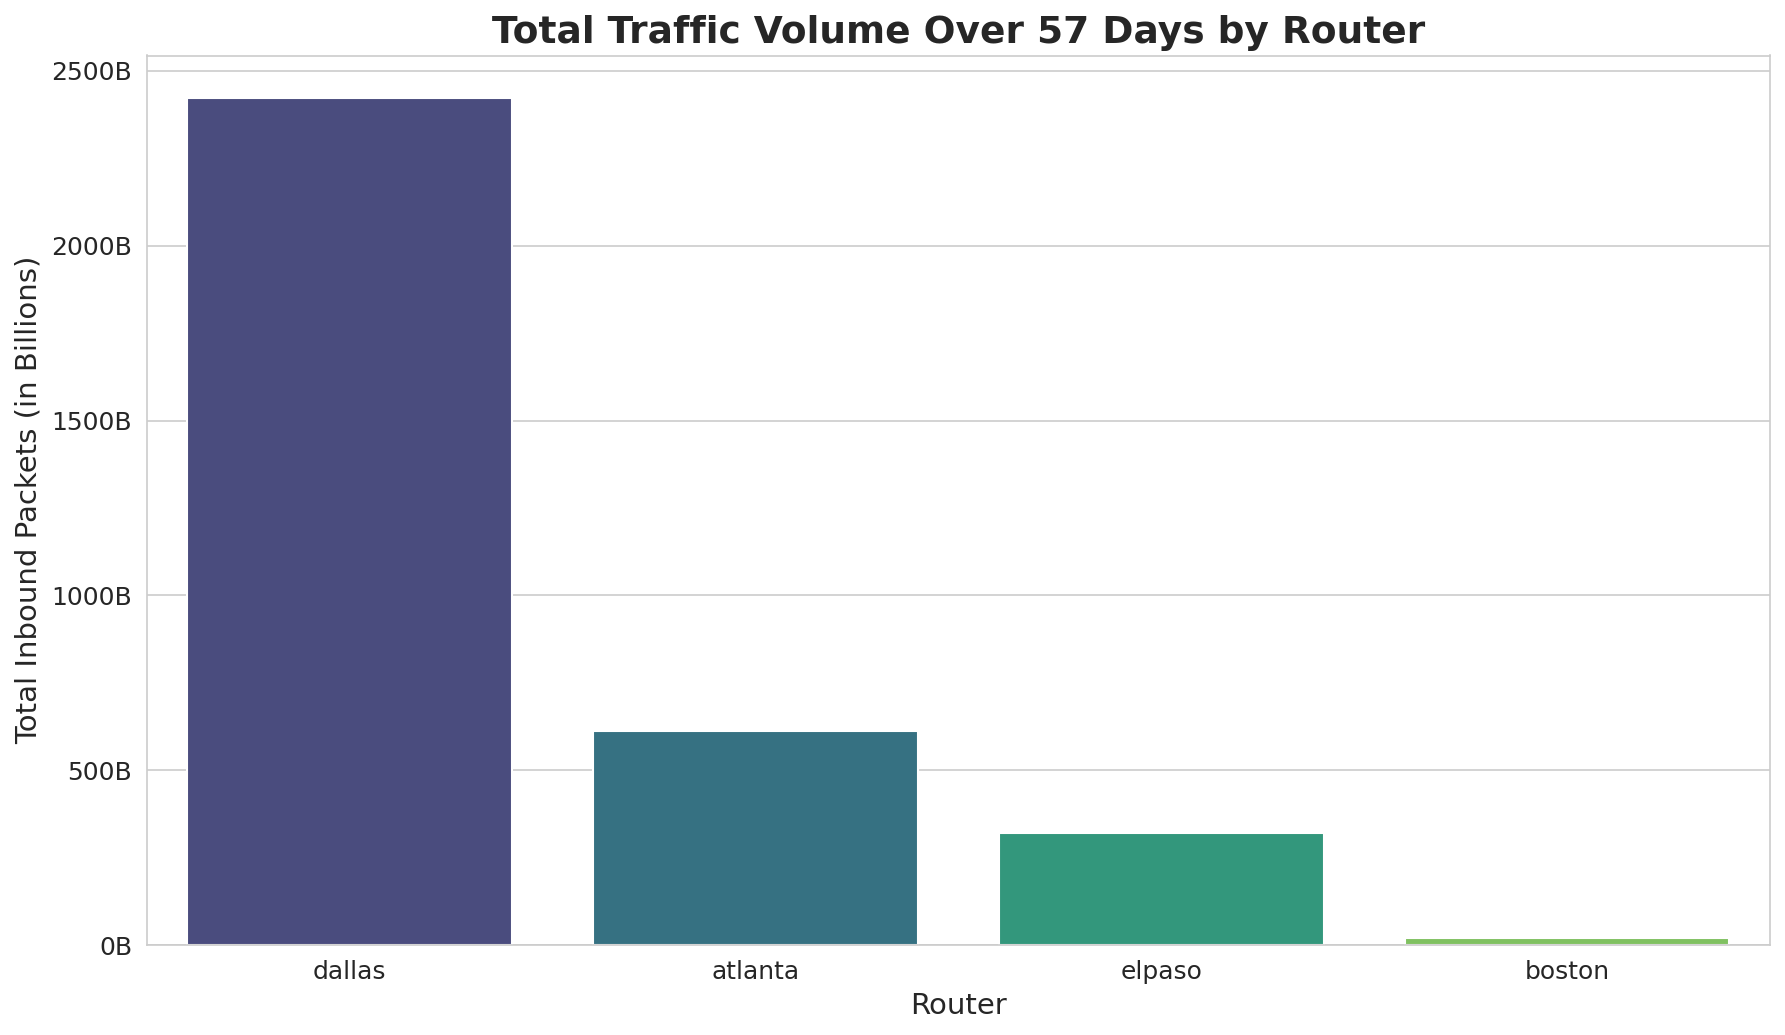


--- Generating Plot 2: Average Daily Traffic Patterns ---
  (This may take a moment as it requires resampling the entire DataFrame...)
  ✅ Plot saved to eda_02_daily_traffic_patterns.pdf


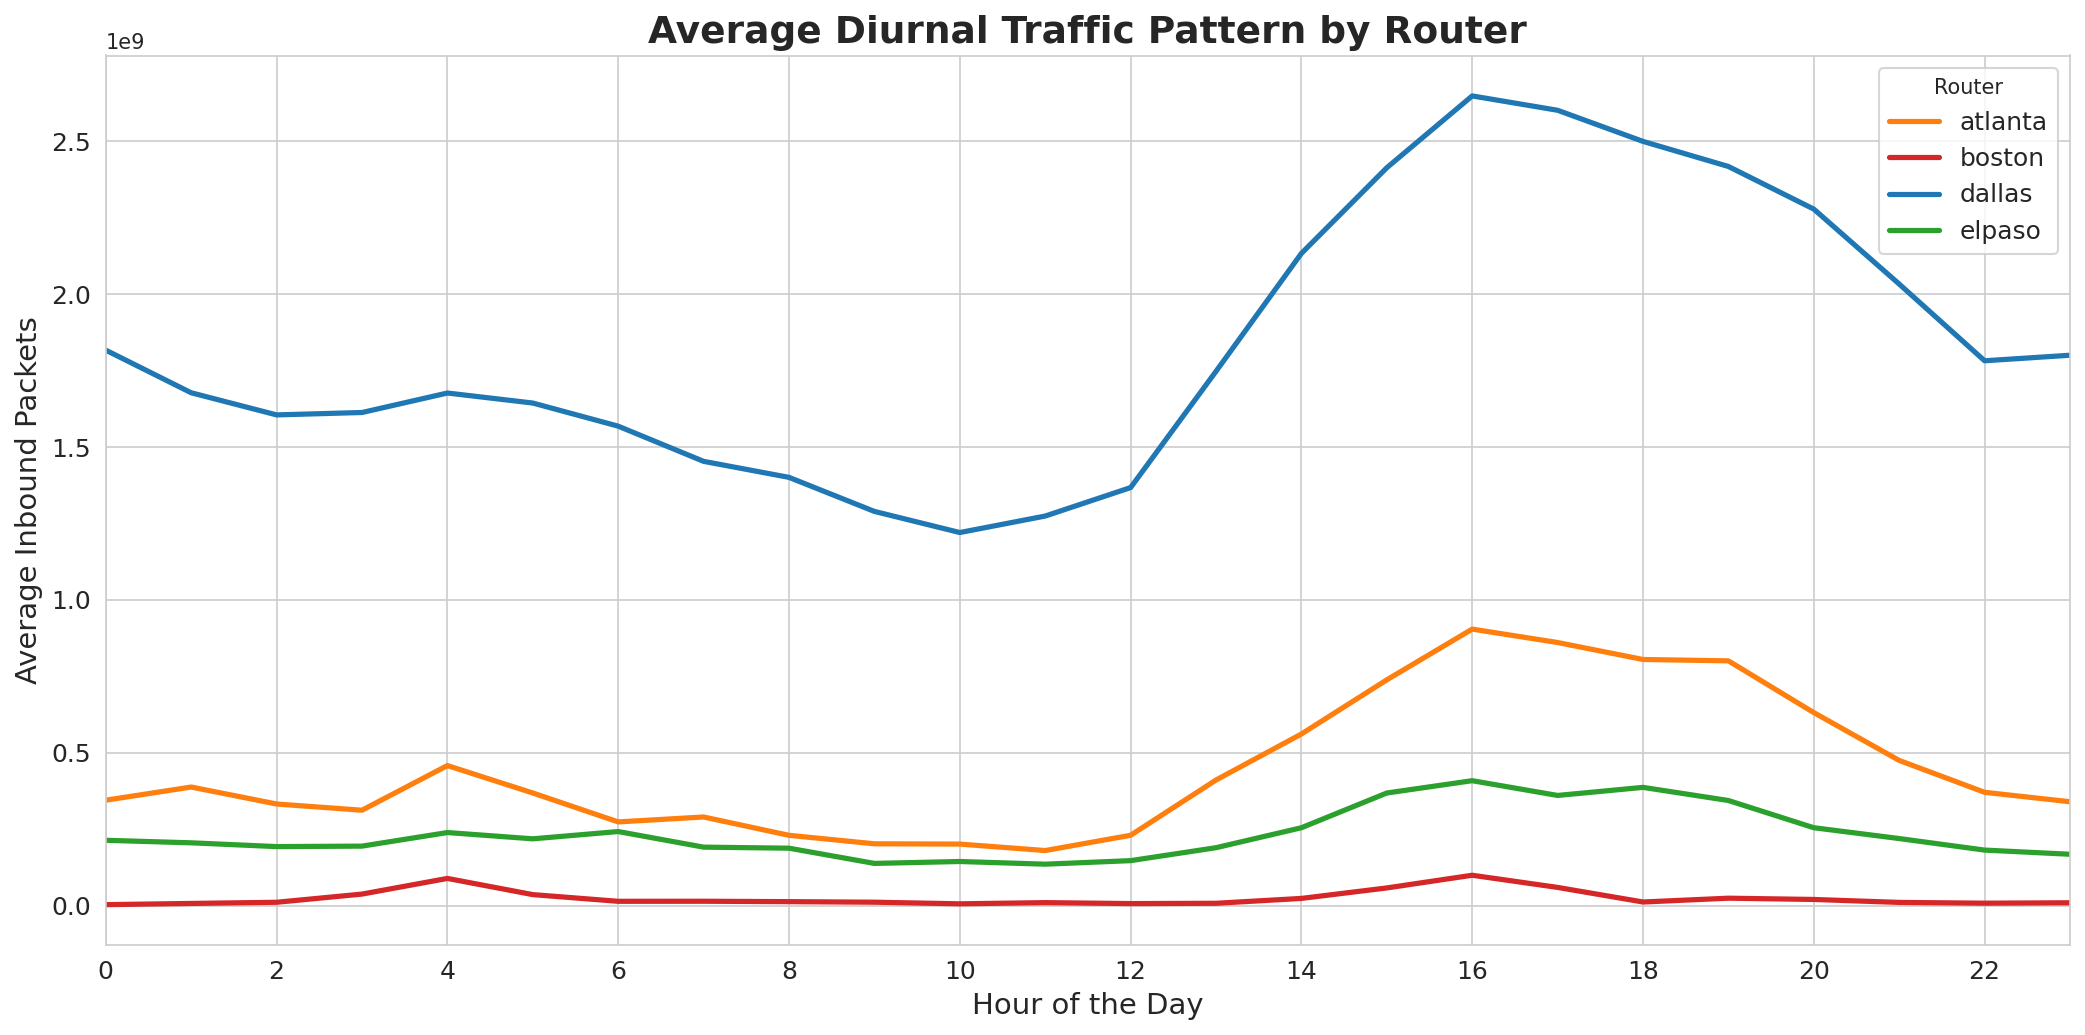


--- Notebook 02_EDA.ipynb Complete ---
All exploratory plots have been saved to the 'outputs/eda' directory.


In [10]:
#
#  notebooks/02_EDA.ipynb
#

################################################################################
#
# Notebook 2: Exploratory Data Analysis (EDA)
#
# --- PURPOSE ---
# This notebook loads the clean, consolidated "golden source" dataset created by
# `01_ETL.ipynb`. Its purpose is to perform exploratory data analysis to:
#   1. Verify the data integrity and structure.
#   2. Generate visualizations that justify the selection of the four routers by
#      highlighting their diverse traffic characteristics (volume and patterns).
#
# --- WORKFLOW ---
# This notebook should be run ONLY AFTER `01_ETL.ipynb` is complete. It can be
# re-run as many times as needed to adjust plot aesthetics without
# affecting any other part of the project.
#
################################################################################


#######################################################################
# CELL 1: ENVIRONMENT SETUP & CONFIGURATION (KNOBS)
# (Run this cell first to set up the environment)
#######################################################################

# --- Imports ---
import warnings
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker # For custom plot tick formatting

print("--- Environment Setup ---")
print(f"Pandas version: {pd.__version__}")

# --- Suppress Warnings for Cleaner Output ---
warnings.filterwarnings("ignore")

# --- Matplotlib and Seaborn Configuration ---
# Ensure plots appear inline in the Jupyter Notebook
%matplotlib inline
# Set a professional plotting style and higher resolution for quality figures
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300

# ---------------------------------------------------------------------------------
# >>> CONFIGURATION KNOBS <<<
# ---------------------------------------------------------------------------------

# --- Input Path ---
# Path to the single, un-aggregated "golden source" Parquet file from Notebook 1.
PROCESSED_DATA_PATH = Path("/mnt/nrdstor/ramamurthy/mhnarfth/internet2/journal_extension_data/journal_study_4r_57d_unaggregated.parquet")

# --- Output Path ---
# Directory where the exploratory plots will be saved.
EDA_FIGURES_DIR = Path("outputs/eda/")

# ---------------------------------------------------------------------------------

# --- Helper Function to Save Plots ---
def save_and_display_plot(fig_name: str):
    """Saves the current matplotlib figure as a PDF file to the EDA_FIGURES_DIR and displays it."""
    # Ensure the output directory exists
    EDA_FIGURES_DIR.mkdir(parents=True, exist_ok=True)
    
    pdf_path = EDA_FIGURES_DIR / f"{fig_name}.pdf"
    
    plt.tight_layout()
    plt.savefig(pdf_path)
    
    print(f"  ✅ Plot saved to {pdf_path.name}")
    plt.show() # Display the plot in the notebook
    plt.close() # Close the figure to free up memory

print("\n--- Configuration Loaded ---")
print(f"Input Data Path: {PROCESSED_DATA_PATH}")
print(f"Output Figures Directory: {EDA_FIGURES_DIR}")
print("--------------------------------\n")


#######################################################################
# CELL 2: DATA LOADING AND VERIFICATION
#######################################################################

print(f"--- Loading data from {PROCESSED_DATA_PATH.name}... ---")

# Initialize df as an empty DataFrame to prevent NameErrors if loading fails
df = pd.DataFrame()

if not PROCESSED_DATA_PATH.exists():
    print(f"[FATAL ERROR] Input data file not found at: {PROCESSED_DATA_PATH}")
    print("Please ensure you have run '01_ETL.ipynb' successfully before running this notebook.")
else:
    try:
        # Load the data into a Pandas DataFrame
        df = pd.read_parquet(PROCESSED_DATA_PATH)
        
        # Convert the timestamp column to datetime objects
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        
        # Set the timestamp as the DataFrame index, which is essential for time series operations
        df.set_index('timestamp', inplace=True)
        
        print(f"  ✅ Data loaded successfully.")
        print(f"  DataFrame contains {len(df):,} rows and covers the period from {df.index.min()} to {df.index.max()}.")
        print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1e9:.2f} GB")
        
        # --- Data Verification ---
        print("\n--- Verifying Data Distribution in Loaded DataFrame ---")
        router_counts = df['router'].value_counts()
        print("Row count per router:")
        print(router_counts)

    except Exception as e:
        print(f"[FATAL ERROR] An error occurred while loading or processing the data file: {e}")


##########################################################################################
# --- BLOCK FOR PLOT 1: Total Traffic Volume per Router ---
# Purpose: To visually confirm the selection of high-traffic and low-traffic routers.
##########################################################################################

#######################################################################
# CELL 3: Plotting Knobs for "Total Traffic Volume"
#######################################################################

# --- Aesthetic Knobs for Plot 1 ---
PLOT1_FIGSIZE = (12, 7)
PLOT1_PALETTE = 'viridis'
PLOT1_TITLE = 'Total Traffic Volume Over 57 Days by Router'
PLOT1_XLABEL = 'Router'
PLOT1_YLABEL = 'Total Inbound Packets (in Billions)'

# Font Sizes
PLOT1_TITLE_FS = 18
PLOT1_LABEL_FS = 14
PLOT1_TICK_FS = 12


#######################################################################
# CELL 4: Code for "Total Traffic Volume" Plot
#######################################################################

if not df.empty:
    print("\n--- Generating Plot 1: Total Traffic Volume per Router ---")

    # Calculate the total sum of 'in_packets' for each router
    total_volume_by_router = df.groupby('router')['in_packets'].sum().sort_values(ascending=False)

    # Create the figure
    plt.figure(figsize=PLOT1_FIGSIZE)

    # Generate the bar plot
    ax = sns.barplot(x=total_volume_by_router.index, y=total_volume_by_router.values, palette=PLOT1_PALETTE)

    # Apply formatting using the knobs
    ax.set_title(PLOT1_TITLE, fontsize=PLOT1_TITLE_FS, weight='bold')
    ax.set_xlabel(PLOT1_XLABEL, fontsize=PLOT1_LABEL_FS)
    ax.set_ylabel(PLOT1_YLABEL, fontsize=PLOT1_LABEL_FS)
    ax.tick_params(axis='x', labelsize=PLOT1_TICK_FS, rotation=0)
    ax.tick_params(axis='y', labelsize=PLOT1_TICK_FS)

    # Format the y-axis to be more readable (e.g., show "150B" instead of 1.5e11)
    def billions_formatter(x, pos):
        return f'{x / 1e9:.0f}B'
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(billions_formatter))

    # Save and display the plot
    save_and_display_plot("eda_01_total_traffic_volume")
else:
    print("\n[SKIPPED] Plot 1: DataFrame is empty. Cannot generate plot.")


##########################################################################################
# --- BLOCK FOR PLOT 2: Average Daily Traffic Patterns ---
# Purpose: To visualize and compare the diurnal (24-hour) patterns of the selected routers.
##########################################################################################

#######################################################################
# CELL 5: Plotting Knobs for "Daily Traffic Patterns"
#######################################################################

# --- Aesthetic Knobs for Plot 2 ---
PLOT2_FIGSIZE = (14, 7)
# Define specific colors for each router for consistency
PLOT2_COLORS = {
    'dallas': '#1f77b4',  # Muted Blue
    'atlanta': '#ff7f0e', # Safety Orange
    'elpaso': '#2ca02c',  # Cooked Asparagus Green
    'boston': '#d62728'   # Brick Red
}
PLOT2_LINEWIDTH = 2.5
PLOT2_TITLE = 'Average Diurnal Traffic Pattern by Router'
PLOT2_XLABEL = 'Hour of the Day'
PLOT2_YLABEL = 'Average Inbound Packets'

# Font Sizes
PLOT2_TITLE_FS = 18
PLOT2_LABEL_FS = 14
PLOT2_TICK_FS = 12
PLOT2_LEGEND_FS = 12


#######################################################################
# CELL 6: Code for "Daily Traffic Patterns" Plot
#######################################################################

if not df.empty:
    print("\n--- Generating Plot 2: Average Daily Traffic Patterns ---")
    print("  (This may take a moment as it requires resampling the entire DataFrame...)")

    # Resample the entire DataFrame to an hourly frequency by summing packets.
    # CRITICAL: We need to group by router first before resampling to handle the multiple time series correctly.
    # This avoids mixing data from different routers in the same time bin.
    list_of_hourly_dfs = []
    for router_name in df['router'].unique():
        # Filter for one router, then resample
        df_router_hourly = df[df['router'] == router_name].resample('1H').sum(numeric_only=True)
        df_router_hourly['router'] = router_name
        list_of_hourly_dfs.append(df_router_hourly)
    
    # Combine the hourly-resampled data for all routers
    df_hourly = pd.concat(list_of_hourly_dfs)

    # Create a new column for the hour of the day (0-23)
    df_hourly['hour_of_day'] = df_hourly.index.hour

    # Calculate the mean traffic for each router at each hour of the day
    daily_patterns = df_hourly.groupby(['router', 'hour_of_day'])['in_packets'].mean().reset_index()

    # Create the figure
    plt.figure(figsize=PLOT2_FIGSIZE)

    # Generate the line plot using Seaborn
    ax = sns.lineplot(
        data=daily_patterns,
        x='hour_of_day',
        y='in_packets',
        hue='router',
        palette=PLOT2_COLORS,
        linewidth=PLOT2_LINEWIDTH
    )

    # Apply formatting using the knobs
    ax.set_title(PLOT2_TITLE, fontsize=PLOT2_TITLE_FS, weight='bold')
    ax.set_xlabel(PLOT2_XLABEL, fontsize=PLOT2_LABEL_FS)
    ax.set_ylabel(PLOT2_YLABEL, fontsize=PLOT2_LABEL_FS)
    ax.tick_params(axis='both', labelsize=PLOT2_TICK_FS)
    ax.set_xticks(range(0, 25, 2)) # Set x-ticks to be every 2 hours
    ax.set_xlim(0, 23)
    ax.legend(title='Router', fontsize=PLOT2_LEGEND_FS)

    # Format the y-axis to use scientific notation
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    # Save and display the plot
    save_and_display_plot("eda_02_daily_traffic_patterns")
else:
    print("\n[SKIPPED] Plot 2: DataFrame is empty. Cannot generate plot.")


#######################################################################
# CELL 7: COMPLETION
#######################################################################
print("\n--- Notebook 02_EDA.ipynb Complete ---")
print(f"All exploratory plots have been saved to the '{EDA_FIGURES_DIR}' directory.")